# Exploration of Popular Spotify Playlists and Songs

In [3]:
# Dependencies and Setup
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import base64
from requests.auth import HTTPBasicAuth
import scipy.stats as st
from pprint import pprint

# Import Spotify API key
from api_keys import spotify_client_id, spotify_client_secret

## Prepare Input & Output Data Files for Reading/Writing Spotify Music Data

In [4]:
# Create playlist dataframe from input csv file that contains a list of playlist IDs, names and genres that we want to search tracks for
playlist_input_df = pd.read_csv("datasets/playlist_top_5_input.csv")
playlist_input_df.head()

# Prepare output csv file path to save the playlists and tracks data retrieved from the Spotify API
spotify_playlists_csv = "datasets/playlist_top_5_output.csv"

## Obtain Spotify's Bearer Token for Authenticating their Web API
* Follow the Client Credentials Flow described [here](https://developer.spotify.com/documentation/general/guides/authorization-guide/#client-credentials-flow)
* Generate a Base64 encoded string using your Spotify client_id and client_secret combination
* Use the Base64 encoded string to obtain the Bearer token

In [5]:
"""
Code to manage Spotify's Client Credentials Flow
"""
# Build the Spotify Client ID and Secret combination
spotify_client_id_secret = spotify_client_id + ":" + spotify_client_secret
# Generate the base64 encoded string that contains the client ID and client secret key
base64_encoding = base64.b64encode(spotify_client_id_secret.encode()).decode()

# Build the Spotify API URL to get the Bearer token
spotify_token_url = 'https://accounts.spotify.com/api/token'

# Build the payload, i.e. the request body parameters that need to be passed to the token API URL
payload = 'grant_type=client_credentials'
# Build the header for Content-Type and Basic Auth containing the base64 encoded string so we can generate the Spotify API token
token_api_headers = { 'Content-Type': 'application/x-www-form-urlencoded', 'Authorization': 'Basic %s' % base64_encoding }

# Call the token API URL and save as a JSON response object
spotify_token_response = requests.post(spotify_token_url, headers=token_api_headers, data=payload).json()
# Retrieve the Bearer token from the response object
spotify_access_token = spotify_token_response['access_token']

## Retrieve Music Data using the [Get Playlist's Tracks API](https://developer.spotify.com/documentation/web-api/reference/playlists/get-playlists-tracks/)

In [6]:
"""
Code to retrieve a Spotify Playlist's Tracks and related data
"""
# Grab Playlist IDs and Names
playlist_ids = playlist_input_df["Playlist ID"]
playlist_names = playlist_input_df["Name"]

# Initialize lists to save playlist data
play_ids = []
track_ids = []
track_position = []
track_added_at = []
track_names = []
track_popularity = []
track_durations = []
artists = []
albums = []
album_types = []
release_dates = []
num_available_markets = []

# Variable to store all unique artists retrieved
all_artists = []
playlist_name = ''

print(f"-" * 150)

# Loop through each Playlist to grab the individual tracks in it
for playlist_id in playlist_ids:

    # Handle any exceptions for Spotify's Get Playlist's Tracks API
    try:
        # Build Spotify's Get Playlist's Tracks URL
        spotify_playlists_url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
        # Build the header for Bearer token containing the base64 encoded string so we can retrieve the playlist's tracks 
        playlist_api_headers = { 'Authorization': 'Bearer %s' % spotify_access_token }
        # Call the Get Playlist's Tracks API URL and save as a JSON response object
        spotify_playlists_response = requests.get(spotify_playlists_url, headers=playlist_api_headers, data={}).json()
        
        # Get total tracks contained in playlist
        total_tracks = spotify_playlists_response['total']
        # Number of tracks that can be retrieved (Spotify limit = 100)
        track_limit = len(spotify_playlists_response['items'])

        # Playlist returns a track object which we will parse to retrieve all the track, album and artist data
        for item in range(track_limit):
            
            # Check if a track has a video
            if spotify_playlists_response['items'][item]['track'] is not None:
               
                # Get the playlist ID and add to a list in order to populate in our DataFrame later
                play_ids.append(playlist_id)
                # Get the track position
                track_position.append(item + 1)
                # Get the date and time the track was added to the playlist 
                track_added_at.append(spotify_playlists_response['items'][item]['added_at'])
                # Get the ID of the track 
                track_ids.append(spotify_playlists_response['items'][item]['track']['id'])
                # Get the name of the track
                track_names.append(spotify_playlists_response['items'][item]['track']['name'])
                # Get the popularity score of the track
                track_popularity.append(spotify_playlists_response['items'][item]['track']['popularity'])
                # Get the track duration (song length) in milliseconds
                track_durations.append(spotify_playlists_response['items'][item]['track']['duration_ms'])
                # Get the number of markets that the track is available in
                num_available_markets.append(len(spotify_playlists_response['items'][item]['track']['available_markets']))
                # Get the album name
                albums.append(spotify_playlists_response['items'][item]['track']['album']['name'])
                # Get the album type: single, album or compilation
                album_types.append(spotify_playlists_response['items'][item]['track']['album']['album_type'])
                # Get the album release date
                release_dates.append(spotify_playlists_response['items'][item]['track']['album']['release_date'])

                # Each track could be associated with one or more artists
                # Parse through each artist object to retrieve their names
                artist_name = ''
                artists_count = len(spotify_playlists_response['items'][item]['track']['artists'])
                for artist in range(artists_count):
                    a_name = spotify_playlists_response['items'][item]['track']['artists'][artist]['name']
                    all_artists.append(a_name)
                    artist_name = artist_name + '|' + a_name

                artists.append(artist_name)
                
       # playlist_name = playlist_input_df[playlist_input_df['Playlist ID'] == playlist_id]['Name']
        #playlist_name = playlist_input_df.query(f'Playlist ID=={playlist_id}')['Name']
        playlist_name = playlist_input_df.loc[playlist_input_df['Playlist ID'] == playlist_id, 'Name'].item()
        print(f"Finished processing Playlist \"{playlist_name}\" with total tracks: {total_tracks} | Retrieval limited to {track_limit}")
        #print(f"Finished processing Playlist {playlist_id} with total tracks: {total_tracks} | Retrieval limited to {track_limit}")

    # Catch any exceptions thrown by the Spotify API
    except Exception as e:
        print(e)
        pass

# This removes all duplicate artist entries so we have a unique list of artists
all_artists = list(set(all_artists))

print(f"-" * 150)
print(f"Found a total of {len(all_artists)} unique Artists")

------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\Admin\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: `item` has been deprecated and will be removed in a future version


Finished processing Playlist "Today's Top Hits" with total tracks: 50 | Retrieval limited to 50
Finished processing Playlist "Pop Rising" with total tracks: 77 | Retrieval limited to 77
Finished processing Playlist "New Music Friday" with total tracks: 100 | Retrieval limited to 100
Finished processing Playlist "Mega Hit Mix" with total tracks: 75 | Retrieval limited to 75
Finished processing Playlist "Just Good Music" with total tracks: 76 | Retrieval limited to 76
Finished processing Playlist "RapCaviar" with total tracks: 54 | Retrieval limited to 54
Finished processing Playlist "Get Turnt" with total tracks: 100 | Retrieval limited to 100
Finished processing Playlist "Fellin' Myself" with total tracks: 50 | Retrieval limited to 50
Finished processing Playlist "Most Necessary" with total tracks: 100 | Retrieval limited to 100
Finished processing Playlist "Hip-Hop Classics" with total tracks: 48 | Retrieval limited to 48
Finished processing Playlist "Hot Country" with total tracks: 5

## Retrieve the Audio Features of Tracks using [Spotify's web API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features)

In [7]:
"""
Code to retrieve a Track's Audio Features using the Spotify Web API.
"""
# Initialize audio track feature lists and variables to save data to
track_key = []
track_mode = []
track_time_signature = []
track_acousticness = []
track_danceability = []
track_energy = []
track_instrumentalness = []
track_liveness = []
track_loudness = []
track_speechiness = []
track_valence = []
track_tempo = []
track_count = 0

# Loop through each track to grab the individual audio features associated with it
print (f"Started retrieving audio features data for all {len(track_ids)} tracks across {len(playlist_ids)} different playlists")
print ("This may take a while, so hang tight...")

for track_id in track_ids:
    
    # Increment track counter for using in the print log
    track_count = track_count + 1

    # Handle any exceptions for Spotify's Get Audio Features API
    try:
        # Build Spotify's Get Playlist's Tracks URL
        spotify_tracks_url = f'https://api.spotify.com/v1/audio-features/{track_id}'
        # Build the header for Bearer token containing the base64 encoded string so we can retrieve the playlist's tracks 
        audio_features_api_headers = { 'Authorization': 'Bearer %s' % spotify_access_token }
        # Call the Get Playlist's Tracks API URL and save into response objects
        audio_features_status = requests.get(spotify_tracks_url, headers=audio_features_api_headers, data={})
        audio_features_response = audio_features_status.json()

        # If API returns successful response go ahead and retrieve the data 
        if  audio_features_status.status_code == 200:
            # Grab all the audio features from the track and save to respective lists
            track_key.append(audio_features_response['key'])
            track_mode.append(audio_features_response['mode'])
            track_time_signature.append(audio_features_response['time_signature'])
            track_acousticness.append(audio_features_response['acousticness'])
            track_danceability.append(audio_features_response['danceability'])
            track_energy.append(audio_features_response['energy'])
            track_instrumentalness.append(audio_features_response['instrumentalness'])
            track_liveness.append(audio_features_response['liveness'])
            track_loudness.append(audio_features_response['loudness'])
            track_speechiness.append(audio_features_response['speechiness'])
            track_valence.append(audio_features_response['valence'])
            track_tempo.append(audio_features_response['tempo'])
        
        # If API response results in a HTTP status code 429 it means Too Many Requests - Rate limiting has been applied
        # We check the Retry-After header in the response to get the number of seconds to wait, before retrying the next request
        elif audio_features_status.status_code == 429:
            retry_after = int(audio_features_status.headers["Retry-After"])
            print (f"Waiting for {retry_after} seconds before attempting the next request")
            time.sleep(retry_after)
        # Catch any exceptions thrown by the Spotify API
    except Exception as e:
        print(e)
        pass
    
    if track_count % 100 == 0:
        print(f"Done retrieving data for {track_count} tracks; moving on to the next set, keep hanging tight...")

print (f"Finished gathering audio features data for a total of {len(track_ids)} tracks across {len(playlist_ids)} different playlists!")

Started retrieving audio features data for all 4428 tracks across 60 different playlists
This may take a while, so hang tight...
Done retrieving data for 100 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 200 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 300 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 400 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 500 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 600 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 700 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 800 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 900 tracks; moving on to the next set, keep hanging tight...
Done retrieving data for 1000 tracks; moving on to the next set, keep hanging tight...
Done retri

## Generate a clean DataFrame of the Spotify Playlists and Tracks Data

In [8]:
# Convert all playlist and track data lists to Series type
# Using the Series type allows us to insert columns with unequal lengths into a DataFrame

play_ids_series = pd.Series(play_ids, name='Playlist ID')
track_ids_series = pd.Series(track_ids, name='Track ID')
track_position_series = pd.Series(track_position, name='Track Position')
track_names_series = pd.Series(track_names, name='Track Name')
track_added_at_series = pd.Series(track_added_at, name='Track Added At')
track_popularity_series = pd.Series(track_popularity, name='Track Popularity')
track_durations_series = pd.Series(track_durations, name='Track Duration')
num_available_markets_series = pd.Series(num_available_markets, name='Available Markets')
albums_series = pd.Series(albums, name='Album')
album_types_series = pd.Series(album_types, name='Album Type')
artists_series = pd.Series(artists, name='Artist')
release_dates_series = pd.Series(release_dates, name='Release Date')
track_key_series = pd.Series(track_key, name='Key')
track_mode_series = pd.Series(track_mode, name='Mode')
track_time_signature_series = pd.Series(track_time_signature, name='Time Signature')
track_acousticness_series = pd.Series(track_acousticness, name='Acousticness')
track_danceability_series = pd.Series(track_danceability, name='Danceability')
track_energy_series = pd.Series(track_energy, name='Energy')
track_instrumentalness_series = pd.Series(track_instrumentalness, name='Instrumentalness')
track_liveness_series = pd.Series(track_liveness, name='Liveness')
track_loudness_series = pd.Series(track_loudness, name='Loudness')
track_speechiness_series = pd.Series(track_speechiness, name='Speechiness')
track_valence_series = pd.Series(track_valence, name='Valence')
track_tempo_series = pd.Series(track_tempo, name='Tempo')

# Concatenate/Convert all the Series columns into a DataFrame 
play_df = pd.concat([play_ids_series, track_ids_series, track_position_series, track_names_series, track_added_at_series,track_popularity_series, track_durations_series, num_available_markets_series, albums_series, album_types_series, artists_series,release_dates_series, track_key_series, track_mode_series, track_time_signature_series, track_acousticness_series,track_danceability_series, track_energy_series, track_instrumentalness_series, track_liveness_series, track_loudness_series,track_speechiness_series, track_valence_series, track_tempo_series], axis=1)

# Drop any tracks where audio features have Null/NA/NaN values 
playlist_output_df = play_df.dropna()

# Export the playlists' tracks data to a csv file
playlist_output_df.to_csv(spotify_playlists_csv, index=False)

# Confirm the DataFrame counts look OK
print (playlist_output_df.count())

# Display the playlists' tracks data frame
playlist_output_df.head()

Playlist ID          4428
Track ID             4428
Track Position       4428
Track Name           4428
Track Added At       4428
Track Popularity     4428
Track Duration       4428
Available Markets    4428
Album                4428
Album Type           4428
Artist               4428
Release Date         4428
Key                  4428
Mode                 4428
Time Signature       4428
Acousticness         4428
Danceability         4428
Energy               4428
Instrumentalness     4428
Liveness             4428
Loudness             4428
Speechiness          4428
Valence              4428
Tempo                4428
dtype: int64


,Playlist ID,Track ID,Track Position,Track Name,Track Added At,Track Popularity,Track Duration,Available Markets,Album,Album Type,...,Time Signature,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo
0,37i9dQZF1DXcBWIGoYBM5M,6WrI0LAC5M1Rw2MnX2ZvEg,1,Don't Start Now,2020-02-03T05:01:00Z,97,183290,75,Don't Start Now,single,...,4,0.01250,0.794,0.793,0.000000,0.0952,-4.521,0.0842,0.677,123.941
1,37i9dQZF1DXcBWIGoYBM5M,0sf12qNH5qcw8qpgymFOqD,2,Blinding Lights,2020-02-03T05:01:00Z,98,201573,79,Blinding Lights,single,...,4,0.00147,0.513,0.796,0.000209,0.0938,-4.075,0.0629,0.345,171.017
2,37i9dQZF1DXcBWIGoYBM5M,4TnjEaWOeW0eKTKIEvJyCa,3,Falling,2020-02-03T05:01:00Z,97,159381,79,Falling,single,...,4,0.12300,0.784,0.430,0.000000,0.0887,-8.756,0.0364,0.236,127.087
3,37i9dQZF1DXcBWIGoYBM5M,0nbXyq5TXYPCO7pr3N8S4I,4,The Box,2020-02-03T05:01:00Z,100,196652,78,Please Excuse Me For Being Antisocial,album,...,4,0.10400,0.896,0.586,0.000000,0.7900,-6.687,0.0559,0.642,116.971
4,37i9dQZF1DXcBWIGoYBM5M,2usxQITOSDqvkYiI0oIwao,5,You should be sad,2020-02-03T05:01:00Z,88,205473,0,You should be sad,single,...,4,0.14300,0.591,0.585,0.000000,0.1090,-6.350,0.0277,0.324,110.940


### Created a Merged DataFrame for further analysis

In [9]:
# Merge the input and output DataFrames for Playlists data 
merged_playlist_data = pd.merge(playlist_input_df, playlist_output_df, on = "Playlist ID", how = "inner")

# Verify the merged DatFrame counts
merged_playlist_data.count()

Name                 4428
Genre                4428
Playlist ID          4428
Track ID             4428
Track Position       4428
Track Name           4428
Track Added At       4428
Track Popularity     4428
Track Duration       4428
Available Markets    4428
Album                4428
Album Type           4428
Artist               4428
Release Date         4428
Key                  4428
Mode                 4428
Time Signature       4428
Acousticness         4428
Danceability         4428
Energy               4428
Instrumentalness     4428
Liveness             4428
Loudness             4428
Speechiness          4428
Valence              4428
Tempo                4428
dtype: int64

## Display some basic Stats for the Music Data that we retrieved  

### Average Popularity Score of Songs by Genre
* Pop, Latin, Hip Hop, Country and R&B are by far the most popular Playlist Genres on Spotify  

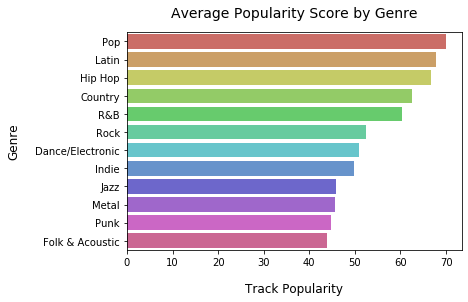

In [10]:
# Group Playlists DataFrame by Genre
genre_group = merged_playlist_data.groupby(['Genre'])

# Create a DataFrame with the average popularity score of each playlist track and sort it from highest to lowest score 
genre_avg_pop = genre_group['Track Popularity'].mean()
genre_avg_pop = genre_avg_pop.sort_values(ascending = False)
genre_avg_op_df = genre_avg_pop.to_frame()
genre_avg_op_df = genre_avg_op_df.reset_index()

# Create a Bar Plot using seaborn and save the image
sns.set_palette("hls",len(genre_group['Genre']))
ax = sns.barplot(x="Track Popularity", y="Genre", data=genre_avg_op_df)
ax.set_title("Average Popularity Score by Genre", fontsize=14, pad=15)
ax.set_xlabel('Track Popularity', fontsize=12, labelpad=15)
ax.set_ylabel('Genre', fontsize=12, labelpad=15)
fig = ax.get_figure()
fig.savefig("plots/Average_Popularity_Score_Genre.png", bbox_inches='tight', dpi=200)

### Distribution of Songs based on the Type of Album
* Out of the sampled dataset of playlists' tracks, it is evident that songs released as singles are more popular than the ones that are released as part of full-length albums.
* Compilations on the other hand, barely made the cut.

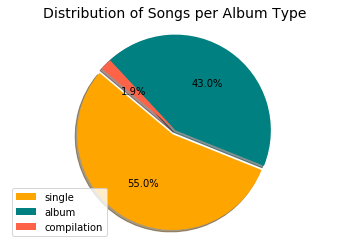

In [11]:
# Get the number of tracks for each Album type
album_type_tracks = merged_playlist_data["Album Type"].value_counts()

# Plot a pie chart showing distribution of tracks/songs per Album type
fig, ax = plt.subplots()
colors = ['orange','teal','tomato']
ax.pie(album_type_tracks, explode=(0.05,0,0), autopct="%1.1f%%", shadow=True, startangle=140, colors=colors)
ax.axis("equal")
ax.set_title('Distribution of Songs per Album Type', fontsize=14)
ax.legend(album_type_tracks.index)
fig.savefig("plots/Album_Types_Distribution.png", dpi=200)
#plt.show()

### Audio Features that influence the Popularity of Songs
* Spotify stores [audio feature information](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) for all tracks. We looked at which audio features contribute most towards a song's popularity by calculating the mean measure of each audio feature.
* In general, songs with high **Energy** and **Danceability** are always popular.
* **Valence**, which describes the musical positiveness conveyed by a track is also a strong contributor. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* Songs that have lower **Acousticness** and **Liveness** (i.e. a song that was performed live) are generally more popular as well.
* **Speechiness**, which detects the presence of spoken words in a track has a mean lower than 0.33, which indicates that popular songs comprise mostly of "music" and other "non-speech-like" aspects.
* The mean **Instrumentalness** of songs is also low - which, as expected, indicates that popular songs are less instrumental and more vocal-focused.


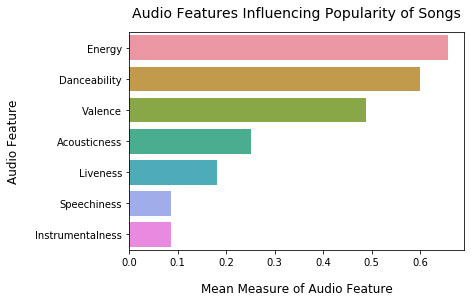

In [12]:
# Calculate the Mean Measure of Audio Features that we are interested in plotting
acousticness = merged_playlist_data["Acousticness"].mean()
danceability = merged_playlist_data["Danceability"].mean()
energy = merged_playlist_data["Energy"].mean()
instrumentalness = merged_playlist_data["Instrumentalness"].mean()
liveness = merged_playlist_data["Liveness"].mean()
speechiness = merged_playlist_data["Speechiness"].mean()
valence = merged_playlist_data["Valence"].mean()

# Craete Data Frame of the Mean Measures
audio_features_df = pd.DataFrame(
    {"Acousticness": [acousticness],
     "Danceability": [danceability],
     "Energy": [energy],
     "Instrumentalness": [instrumentalness],     
     "Liveness": [liveness],
     "Speechiness": [speechiness],
     "Valence": [valence]}, index = ["Mean Measure of Audio Feature"])

# Prepare the DataFrame for plotting
audio_features_df = audio_features_df.swapaxes("index","columns")
audio_features_df.index.names = ['Audio Feature']
audio_features_df = audio_features_df.reset_index()
audio_features_df = audio_features_df.sort_values("Mean Measure of Audio Feature",ascending=False)

# Create Bar Plot using Seaborn
sns.set_palette("GnBu_d")
ax = sns.barplot(x="Mean Measure of Audio Feature", y="Audio Feature", data=audio_features_df)
ax.set_title("Audio Features Influencing Popularity of Songs", fontsize=14, pad=15)
ax.set_xlabel('Mean Measure of Audio Feature', fontsize=12, labelpad=15)
ax.set_ylabel('Audio Feature', fontsize=12, labelpad=15)
fig = ax.get_figure()
# Save plot
fig.savefig("plots/Audio_Features_Influencing_Popularity.png", bbox_inches='tight', dpi=200)

In [13]:
# Convert Release Date to Year only, and store into a new column called Release Year
merged_playlist_data['Release Year'] = pd.DatetimeIndex(merged_playlist_data['Release Date']).year
merged_playlist_data.head()

# Group the DataFrame by Year
release_year_data = merged_playlist_data.groupby(['Release Year'])

# Print the Number of Tracks being analyzed per Release Year
tracks_by_year = release_year_data['Track ID'].count()
tracks_by_year_df = tracks_by_year.to_frame()
tracks_by_year_df.head(100)

,Track ID
Release Year,
1951,1
1953,1
1954,1
1956,2
1957,3
...,...
2016,99
2017,189
2018,395
